In [1]:
import sys 
sys.path.append('../..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import numpy as np
import torch as ch
from torch import Tensor
import torch.nn as nn
from torch.distributions import Gumbel, Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import datetime
from delphi.oracle import oracle
from delphi import train
from delphi.utils import constants as consts

# set default tensor type 
ch.set_default_tensor_type(ch.cuda.FloatTensor)

# Constants

In [23]:
TRUNCATED_STORE_PATH = '/home/pstefanou/MultinomialLogisticRegression/Truncated/'
STANDARD_STORE_PATH = '/home/pstefanou/MultinomialLogisticRegression/Standard/'

TRUNCATED_EVAL_STORE_PATH = '/home/pstefanou/MultinomialLogisticRegression/TruncatedTest/'
STANDARD_EVAL_STORE_PATH = '/home/pstefanou/MultinomialLogisticRegression/StandardTest/'

# Helper Functions

In [33]:
# membership oracles
class DNN_Lower(oracle): 
    """
    Lower bound truncation on the DNN logits.
    """
    def __init__(self, lower): 
        self.lower = lower
        
    def __call__(self, x): 
        return (x > self.lower).float()


class Identity(oracle): 
    def __call__(self, x): 
        return ch.ones(x.size())

def plot():
    # TRUNCATED CE LOSS DATA
    trunc_reader = CollectionReader(TRUNCATED_STORE_PATH)
    trunc_logs = trunc_reader.df(consts.LOGS_TABLE)
    trunc_reader.close() # close reader

    # STANDARD CE LOSS DATA
    standard_reader = CollectionReader(STANDARD_STORE_PATH)
    standard_logs = standard_reader.df(consts.LOGS_TABLE)
    standard_reader.close() # close reader

    # TEST SET RESULTS 
    trunc_test_reader = CollectionReader(TRUNCATED_EVAL_STORE_PATH)
    trunc_test_results = trunc_test_reader.df(consts.EVAL_LOGS_TABLE)
    trunc_test_reader.close() # close reader

    # TEST SET RESULTS 
    standard_test_reader = CollectionReader(STANDARD_EVAL_STORE_PATH)
    standard_test_results = standard_test_reader.df(consts.EVAL_LOGS_TABLE)
    standard_test_reader.close() # close reader

    sns.lineplot(data=trunc_logs, x='epoch', y='train_loss', label='Train Loss')
    sns.lineplot(data=standard_logs, x='epoch', y='train_loss', label='Naive Train Loss')
    sns.lineplot(data=trunc_logs, x='epoch', y='val_loss', color='red', label='Trunc Val Loss')
    ax = sns.lineplot(data=standard_logs, x='epoch', y='val_loss', color='red', label='Naive Val Loss')
    ax.set(xlabel='epoch', ylabel='CE Loss')
    plt.show()

    sns.lineplot(data=trunc_logs, x='epoch', y='train_prec1', label='Trunc Train Acc')
    sns.lineplot(data=standard_logs, x='epoch', y='train_prec1', label='Naive Train Acc')
    sns.lineplot(data=trunc_logs, x='epoch', y='val_prec1', label='Trunc Val Acc')
    ax = sns.lineplot(data=standard_logs, x='epoch', y='val_prec1', label='Naive Val Acc')
    ax.set(xlabel='epoch', ylabel='Accuracy')
    plt.show()

    print("Standard Test Accuracy: {}".format(standard_test_results['test_prec1']))
    print("Truncated Test Accuracy: {}".format(trunc_test_results['test_prec1']))

# CE Latent Variable Model Loss

In [26]:
class GumbelCE(ch.autograd.Function):
    @staticmethod
    def forward(ctx, pred, targ):
        ctx.save_for_backward(pred, targ)
        ce_loss = ch.nn.CrossEntropyLoss()
        return ce_loss(pred, targ)

    @staticmethod
    def backward(ctx, grad_output):
        pred, targ = ctx.saved_tensors
        # initialize gumbel distribution
        gumbel = Gumbel(0, 1)
        # make num_samples copies of pred logits
        stacked = pred[None, ...].repeat(args.num_samples, 1, 1)        
        # add gumbel noise to logits
        rand_noise = gumbel.sample(stacked.size())
        noised = stacked + rand_noise 
        noised_labs = noised.argmax(-1)
        # remove the logits from the trials, where the kth logit is not the largest value
        good_mask = noised_labs.eq(targ)[..., None]
        inner_exp = 1 - ch.exp(-rand_noise)
        avg = (inner_exp * good_mask).sum(0) / (good_mask.sum(0) + 1e-5) / pred.size(0)
        return -avg , None
    
class TruncatedGumbelCE(ch.autograd.Function):
    @staticmethod
    def forward(ctx, pred, targ):
        ctx.save_for_backward(pred, targ)
        ce_loss = ch.nn.CrossEntropyLoss()
        return ce_loss(pred, targ)

    @staticmethod
    def backward(ctx, grad_output):
        pred, targ = ctx.saved_tensors
        # initialize gumbel distribution
        gumbel = Gumbel(0, 1)
        # make num_samples copies of pred logits
        stacked = pred[None, ...].repeat(args.num_samples, 1, 1)   
        # add gumbel noise to logits
        rand_noise = gumbel.sample(stacked.size())
        noised = stacked + rand_noise 
        # truncate - if one of the noisy logits does not fall within the truncation set, remove it
        filtered = ch.all(args.phi(noised).bool(), dim=2).float().unsqueeze(2)
        noised_labs = noised.argmax(-1)
        # mask takes care of invalid logits and truncation set
        mask = noised_labs.eq(targ)[..., None] * filtered
        inner_exp = 1 - ch.exp(-rand_noise)
                
        avg = ((inner_exp * mask).sum(0) / (mask.sum(0) + 1e-5) - (inner_exp * filtered).sum(0) / (filtered.sum(0) + 1e-5)) 
        return -avg / pred.size(0), None, None

# Default Experiment Parameters

In [37]:
# procedure hyperparameters
args = Parameters({ 
    'epochs': 25,
    'num_workers': 0, 
    'batch_size': 100,
    'bias': True,
    'num_samples': 100000,
    'clamp': True, 
    'radius': 5.0, 
    'lr': 1e-1,
    'shuffle': False, 
    'samples': 10000,  # number of samples to generate for ground truth
    'in_features': 10, # number of in-features to multi-log-reg
    'k': 10, # number of classes
    'lower': -1, # lower bound for generating ground truth weights
    'upper': 1,  # upper bound for generating ground truth weights
    'trials': 10,
    'log_iters': 1,    
    'should_save_ckpt': True,
    'save_ckpt_iters': -1,
    'validation_split': .8,
    'momentum': 0.0,
    'weight_decay': 0.0,
    'custom_lr_multiplier': consts.COSINE, 
    'shuffle': True,
})

if ch.cuda.is_available(): 
    args.__setattr__('device', 'cuda')
args

{
  "epochs": 25,
  "num_workers": 0,
  "batch_size": 100,
  "bias": true,
  "num_samples": 100000,
  "clamp": true,
  "radius": 5.0,
  "lr": 0.1,
  "shuffle": true,
  "samples": 10000,
  "in_features": 10,
  "k": 10,
  "lower": -1,
  "upper": 1,
  "trials": 10,
  "log_iters": 1,
  "should_save_ckpt": true,
  "save_ckpt_iters": -1,
  "validation_split": 0.8,
  "momentum": 0.0,
  "weight_decay": 0.0,
  "custom_lr_multiplier": "cosine",
  "device": "cuda"
}

# Truncated Multinomial Logistic Regression Experiments

Experiment Parameters

In [38]:
phi = DNN_Lower(ch.full(ch.Size([args.K,]), -7))
# phi = Identity()

# distributions
gumbel = Gumbel(0, 1)
U = Uniform(args.lower, args.upper) # distribution to generate ground-truth parameters
U_ = Uniform(-5, 5) # distribution to generate samples

# Experiment

In [39]:
# perform number of trials experiments
for i in range(args.trials):
    # generate synthetic data until survival probability of more than 40%
    alpha = None
    while alpha is None or alpha < .3:
        # generate ground-truth from uniform distribution
        ground_truth = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
        ground_truth.weight = nn.Parameter(U.sample(ch.Size([args.K, args.IN_FEATURES])))
        if ground_truth.bias is not None: 
            ground_truth.bias = nn.Parameter(U.sample(ch.Size([args.K,])))
        # independent variable 
        X = U_.sample(ch.Size([args.samples, args.IN_FEATURES]))
        # determine base model logits 
        z = ground_truth(X)
        # apply softmax to unnormalized likelihoods
        y = ch.argmax(ch.nn.Softmax(dim=1)(z), dim=1)

        # TRUNCATE
        trunc = phi(z)
        indices = ch.all(trunc.bool(), dim=1).float().nonzero(as_tuple=False).flatten()
        y_trunc = y[indices]
        x_trunc = X[indices]
        alpha = x_trunc.size(0) / X.size(0)

        # all synthetic data 
        ds = TensorDataset(x_trunc, y_trunc)
        # split ds into training and validation data sets - 80% training, 20% validation
        train_length = int(len(ds)*.8)
        val_length = len(ds) - train_length
        train_ds, val_ds = ch.utils.data.random_split(ds, [train_length, val_length])
        # train and validation loaders
        train_loader = DataLoader(train_ds, num_workers=args.num_workers, batch_size=args.batch_size)
        val_loader = DataLoader(val_ds, num_workers=args.num_workers, batch_size=args.batch_size)
        loaders = (train_loader, val_loader)

        # test dataset
        x_test = X[~indices]
        y_test = y[~indices]
        test_ds = TensorDataset(x_test, y_test)
        test_loader = DataLoader(test_ds, num_workers=args.num_workers, batch_size=args.batch_size)
    
    # new classifier models at the beginning of each trial
    trunc_multi_log_reg = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
    
    # truncated store
    out_store = Store(TRUNCATED_STORE_PATH)
    trunc_ce = TruncatedGumbelCE.apply
    args.__setattr__('custom_criterion', trunc_ce)  # truncated ce loss
    args.__setattr__('phi', phi)
    train.train_model(args, trunc_multi_log_reg, loaders, store=out_store, device=args.device)
    
    # new classifier models at the beginning of each trial
    standard_multi_log_reg = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
    
    # naive ce loss
    out_store = Store(STANDARD_STORE_PATH)
    args.__setattr__('custom_criterion', None) # default ce loss
    train.train_model(args, standard_multi_log_reg, loaders, store=out_store, device=args.device)
    
    # truncated multinomial logistic regression eval
    out_store = Store(TRUNCATED_EVAL_STORE_PATH)
    train.eval_model(args, trunc_multi_log_reg, test_loader, out_store)

    
    # standard multinomial logistic regression eval
    out_store = Store(STANDARD_EVAL_STORE_PATH)
    train.eval_model(args, standard_multi_log_reg, test_loader, out_store)

# Loss and Accuracy Curves

100%|██████████| 12/12 [00:00<00:00, 255.55it/s]


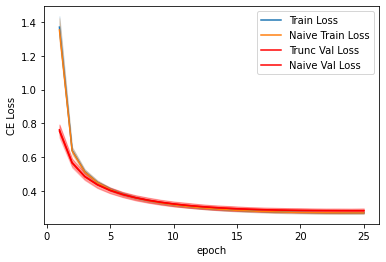

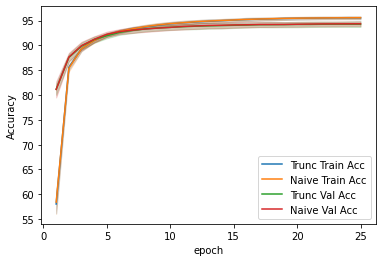

Standard Test Accuracy: 0    93.501961
0    94.887985
0    91.214241
0    94.780281
0    94.178574
0    95.736252
0    94.299400
0    93.794563
0    92.885071
0    90.922485
0    94.839607
0    93.023842
Name: test_prec1, dtype: float64
Truncated Test Accuracy: 0    92.672523
0    91.128792
0    94.012840
0    94.816368
0    91.360184
0    93.414742
0    94.725052
0    92.859009
0    93.741753
0    95.899353
0    94.371262
0    94.691055
Name: test_prec1, dtype: float64


In [40]:
plot()